#DS340 Final Project
## Image Classification of Luggage X-ray Dataset

##### For this project, we use this dataset from: https://universe.roboflow.com/airport-security-scanning/airport-security-scans-dataset.

As you can see in this data set we have images of X-rays of luggage and it is classified into 5 different types of contraband. Our goal is to create a model that can accurately classify these images into the correct type of contraband. If AI can be accurate enough to detect contraband in luggage it can make traveling much safer and give an extra set of eyes to TSA.

In [ ]:
from google.colab import drive
import zipfile

zip_path = '/content/drive/MyDrive/ds340/project/data.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/ds340/project/')

print(os.listdir('/content/drive/MyDrive/ds340/project/'))

## Load the data

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/ds340/project/'

data  data1  data_copy	data.zip  idk  __MACOSX  ogdata  originalData


In [ ]:
!ls '/content/drive/MyDrive/ds340/project/data1/test'

'Folding Knife'  'Multi-tool Knife'   Scissor  'Straight Knife'  'Utility Knife'


In [ ]:
import os

train_dir = '/content/drive/MyDrive/ds340/project/data1/train'
valid_dir = '/content/drive/MyDrive/ds340/project/data1/valid'
test_dir = '/content/drive/MyDrive/ds340/project/data1/test'
test = '/content/drive/MyDrive/ds340/project/data1/test'

print(os.listdir(test_dir))
print(os.listdir(test))

['Utility Knife', 'Folding Knife', 'Multi-tool Knife', 'Straight Knife', 'Scissor']
['Utility Knife', 'Folding Knife', 'Multi-tool Knife', 'Straight Knife', 'Scissor']


In [ ]:
from google.colab import drive
import os

def count_files(directory):
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            num_files = len(os.listdir(subdir_path))
            print(f'{subdir} contains {num_files} files')

print("Training Data:")
count_files(train_dir)

print("\nValidation Data:")
count_files(valid_dir)

print("\nTest Data:")
count_files(test_dir)


Training Data:
Utility Knife contains 1110 files
Folding Knife contains 1102 files
Multi-tool Knife contains 1122 files
Straight Knife contains 578 files
Scissor contains 1039 files

Validation Data:
Utility Knife contains 327 files
Folding Knife contains 319 files
Multi-tool Knife contains 330 files
Straight Knife contains 148 files
Scissor contains 291 files

Test Data:
Utility Knife contains 177 files
Folding Knife contains 155 files
Multi-tool Knife contains 149 files
Straight Knife contains 79 files
Scissor contains 147 files


#### Visualize Data Distribution

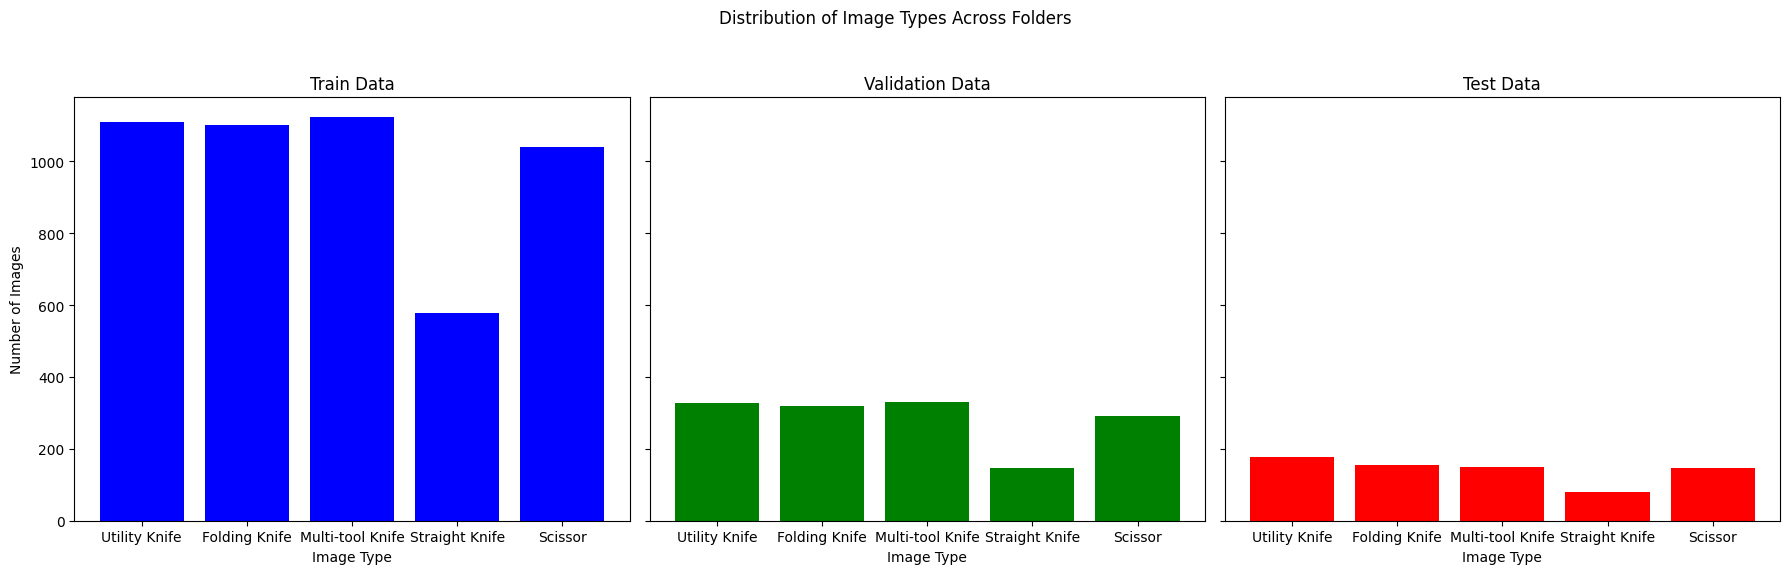

Percentage Distribution Across Folders:

Utility Knife:
  Train: 68.77%
  Valid: 20.26%
  Test: 10.97%

Folding Knife:
  Train: 69.92%
  Valid: 20.24%
  Test: 9.84%

Multi-tool Knife:
  Train: 70.08%
  Valid: 20.61%
  Test: 9.31%

Straight Knife:
  Train: 71.80%
  Valid: 18.39%
  Test: 9.81%

Scissor:
  Train: 70.35%
  Valid: 19.70%
  Test: 9.95%


In [ ]:
import os
import matplotlib.pyplot as plt

base_dirs = {
    'train': train_dir,
    'valid': valid_dir,
    'test': test_dir
}

data_summary = {}
total_files = 0

for key, directory in base_dirs.items():
    data_summary[key] = {}
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            num_files = len([name for name in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, name))])
            data_summary[key][subdir] = num_files
            total_files += num_files

labels = list(data_summary['train'].keys())
train_counts = [data_summary['train'][label] for label in labels]
valid_counts = [data_summary['valid'][label] for label in labels]
test_counts = [data_summary['test'][label] for label in labels]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Distribution of Image Types Across Folders')

axes[0].bar(labels, train_counts, color='b')
axes[0].set_title('Train Data')
axes[0].set_ylabel('Number of Images')
axes[0].set_xlabel('Image Type')

axes[1].bar(labels, valid_counts, color='g')
axes[1].set_title('Validation Data')
axes[1].set_xlabel('Image Type')

axes[2].bar(labels, test_counts, color='r')
axes[2].set_title('Test Data')
axes[2].set_xlabel('Image Type')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Percentage Distribution Across Folders:")
for label in labels:
    total = train_counts[labels.index(label)] + valid_counts[labels.index(label)] + test_counts[labels.index(label)]
    print(f"\n{label}:")
    print(f"  Train: {train_counts[labels.index(label)] / total * 100:.2f}%")
    print(f"  Valid: {valid_counts[labels.index(label)] / total * 100:.2f}%")
    print(f"  Test: {test_counts[labels.index(label)] / total * 100:.2f}%")


## Attempt 1 Multiclass Classification using CNN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 4951 images belonging to 5 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(valid_dir,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 1415 images belonging to 5 classes.


In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Folding Knife
1 : Multi-tool Knife
2 : Scissor
3 : Straight Knife
4 : Utility Knife


In [ ]:
x_batch, y_batch = train_generator.next()
print(x_batch.shape)
print(y_batch.shape)


(32, 224, 224, 3)
(32, 5)


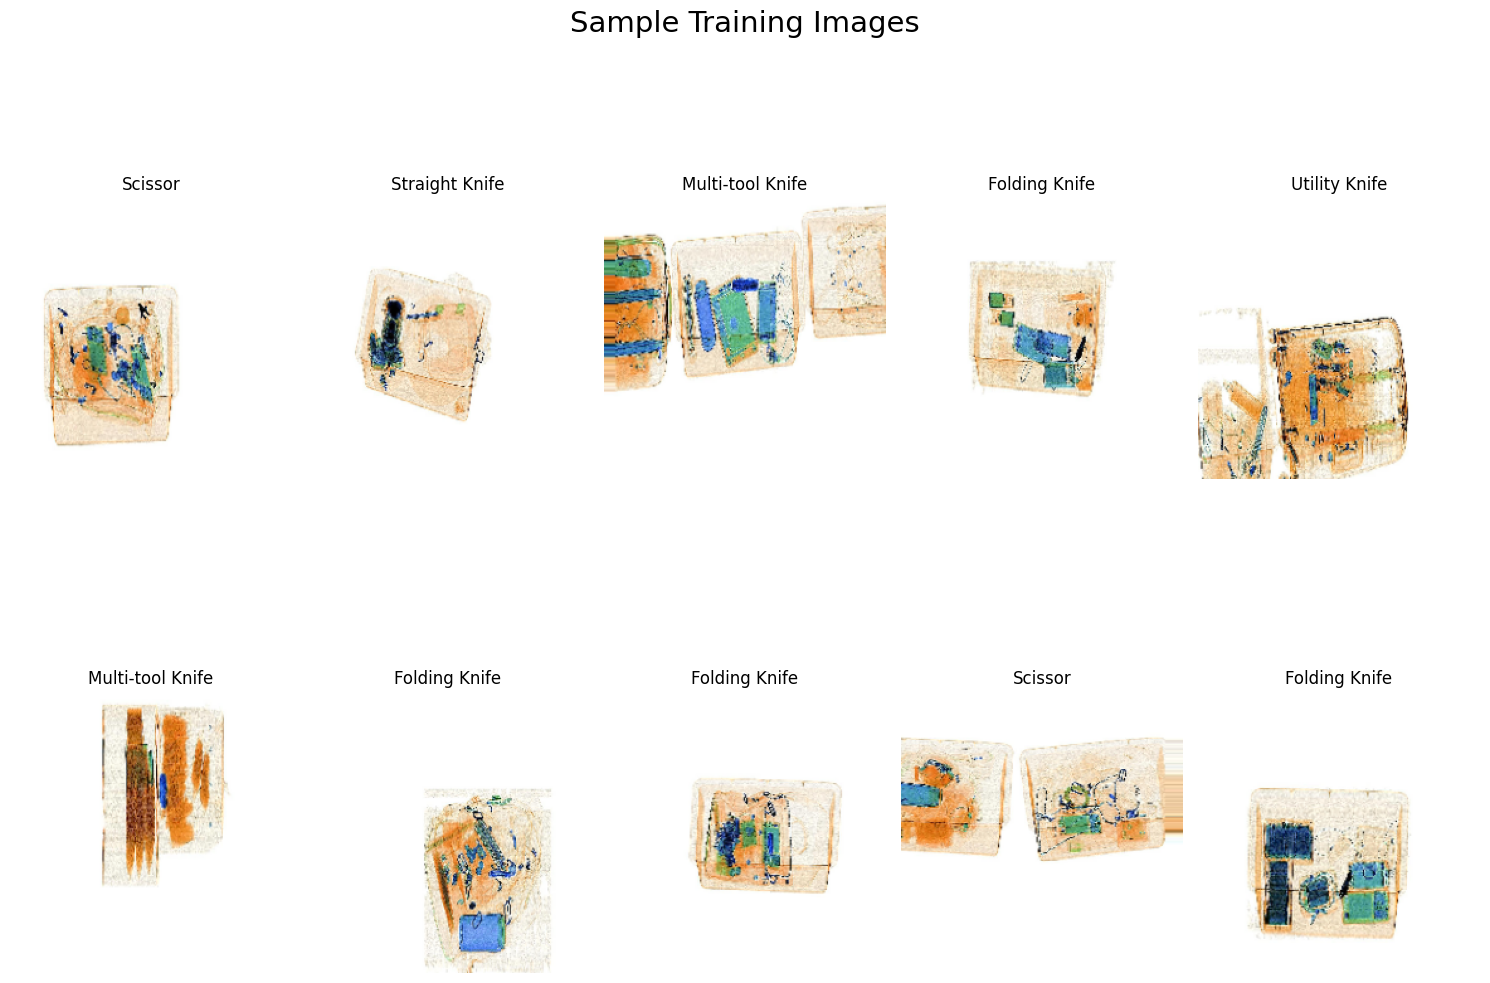

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

### Model #1

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')


Found 4951 images belonging to 5 classes.
Found 1415 images belonging to 5 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),

    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile

<bound method Model.compile of <keras.src.engine.sequential.Sequential object at 0x7bb92d5bc370>>

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 17, 17, 128)      

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/15
100/100 [==============================] - ETA: 0s - loss: 1.6692 - accuracy: 0.2259

100/100 [==============================] - 85s 762ms/step - loss: 1.6692 - accuracy: 0.2259 - val_loss: 1.5784 - val_accuracy: 0.2311
Epoch 2/15
100/100 [==============================] - 57s 570ms/step - loss: 1.5952 - accuracy: 0.2094
Epoch 3/15
100/100 [==============================] - 58s 574ms/step - loss: 1.5849 - accuracy: 0.2203
Epoch 4/15
100/100 [==============================] - 61s 603ms/step - loss: 1.5838 - accuracy: 0.2325
Epoch 5/15
100/100 [==============================] - 61s 607ms/step - loss: 1.5910 - accuracy: 0.2288
Epoch 6/15
100/100 [==============================] - 58s 572ms/step - loss: 1.5857 - accuracy: 0.2375
Epoch 7/15
100/100 [==============================] - 65s 645ms/step - loss: 1.5838 - accuracy: 0.2381
Epoch 8/15
100/100 [==============================] - 67s 660ms/step - loss: 1.5791 - accuracy: 0.2600
Epoch 9/15
100/100 [==============================] - 67s 668ms/step - loss: 1.5556 - accuracy: 0.2800
Epoch 10/15
100/100 [=====================

Wow! 0.8627% accuracy! Don't get your hopes up, way too much overfitting:

tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 50 batches). You may need to use the repeat() function when building your dataset.

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


Found 707 images belonging to 5 classes.
23/23 [==============================] - 11s 485ms/step - loss: 2.7713 - accuracy: 0.2362
Test loss: 2.7713053226470947, Test accuracy: 0.23620933294296265


In [ ]:
train_count = sum(len(files) for _, _, files in os.walk(train_dir))
valid_count = sum(len(files) for _, _, files in os.walk(valid_dir))
test_count = sum(len(files) for _, _, files in os.walk(test_dir))

print(f"Training Images: {train_count}")
print(f"Validation Images: {valid_count}")
print(f"Test Images: {test_count}")


Training Images: 4951
Validation Images: 1415
Test Images: 707


In [ ]:
batch_size = 32

train_steps_per_epoch = math.ceil(4951 / batch_size)
validation_steps = math.ceil(1415 / batch_size)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)


history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_steps
)



Found 4951 images belonging to 5 classes.
Found 1415 images belonging to 5 classes.
Epoch 1/15
155/155 [==============================] - 123s 776ms/step - loss: 0.2515 - accuracy: 0.9226 - val_loss: 3.2658 - val_accuracy: 0.2360
Epoch 2/15
155/155 [==============================] - 122s 786ms/step - loss: 0.0451 - accuracy: 0.9903 - val_loss: 4.5393 - val_accuracy: 0.2481
Epoch 3/15
155/155 [==============================] - 121s 777ms/step - loss: 0.0125 - accuracy: 0.9976 - val_loss: 5.2755 - val_accuracy: 0.2459
Epoch 4/15
155/155 [==============================] - 128s 827ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 5.8707 - val_accuracy: 0.2459
Epoch 5/15
155/155 [==============================] - 130s 837ms/step - loss: 5.5952e-04 - accuracy: 1.0000 - val_loss: 6.2525 - val_accuracy: 0.2438
Epoch 6/15
155/155 [==============================] - ETA: 0s - loss: 3.7106e-04 - accuracy: 1.0000

KeyboardInterrupt: 

No changes in overfitting ^

### Model 2 (Pooling and Early Stopping)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=155,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=45,
    callbacks=[early_stopping]
)


Epoch 1/10
155/155 [==============================] - 117s 743ms/step - loss: 9.9326 - accuracy: 0.2212 - val_loss: 3.7233 - val_accuracy: 0.2332
Epoch 2/10
155/155 [==============================] - 112s 724ms/step - loss: 2.6480 - accuracy: 0.2333 - val_loss: 2.0341 - val_accuracy: 0.2254
Epoch 3/10
155/155 [==============================] - 111s 718ms/step - loss: 1.8144 - accuracy: 0.2377 - val_loss: 1.6963 - val_accuracy: 0.2537
Epoch 4/10
155/155 [==============================] - 113s 726ms/step - loss: 1.6517 - accuracy: 0.2420 - val_loss: 1.6206 - val_accuracy: 0.2410
Epoch 5/10
155/155 [==============================] - 111s 714ms/step - loss: 1.6185 - accuracy: 0.2474 - val_loss: 1.6198 - val_accuracy: 0.2445
Epoch 6/10
155/155 [==============================] - 110s 710ms/step - loss: 1.6132 - accuracy: 0.2383 - val_loss: 1.6010 - val_accuracy: 0.2396
Epoch 7/10
155/155 [==============================] - 109s 704ms/step - loss: 1.6152 - accuracy: 0.2537 - val_loss: 1.6156 -

### Model 3: Adding Batch Normalization

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=155,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=45,
    callbacks=[early_stopping]
)

Epoch 1/10
155/155 [==============================] - 132s 841ms/step - loss: 2.2808 - accuracy: 0.2208 - val_loss: 1.6533 - val_accuracy: 0.2276
Epoch 2/10
155/155 [==============================] - 110s 707ms/step - loss: 1.6092 - accuracy: 0.2202 - val_loss: 2.3876 - val_accuracy: 0.2276
Epoch 3/10
155/155 [==============================] - 112s 719ms/step - loss: 1.5939 - accuracy: 0.2286 - val_loss: 1.5894 - val_accuracy: 0.2325
Epoch 4/10
155/155 [==============================] - 113s 729ms/step - loss: 1.5922 - accuracy: 0.2264 - val_loss: 1.8622 - val_accuracy: 0.2120
Epoch 5/10
155/155 [==============================] - 113s 731ms/step - loss: 1.5906 - accuracy: 0.2299 - val_loss: 6.4291 - val_accuracy: 0.2615
Epoch 6/10
155/155 [==============================] - 110s 709ms/step - loss: 1.5894 - accuracy: 0.2238 - val_loss: 1.6651 - val_accuracy: 0.2375
Epoch 7/10
155/155 [==============================] - 109s 703ms/step - loss: 1.5906 - accuracy: 0.2323 - val_loss: 1.8815 -

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

23/23 [==============================] - 8s 363ms/step - loss: 1.5875 - accuracy: 0.2107
Test Loss: 1.587489366531372, Test Accuracy: 0.21074964106082916


These base models aren't really getting us anywhere. There were many other variations of hyperparameters that I tried but not above as I simply just changed them within the current models and just ran them again.

## Attempt 2 Let's Try Transfer Learning

### Chart of Different Models

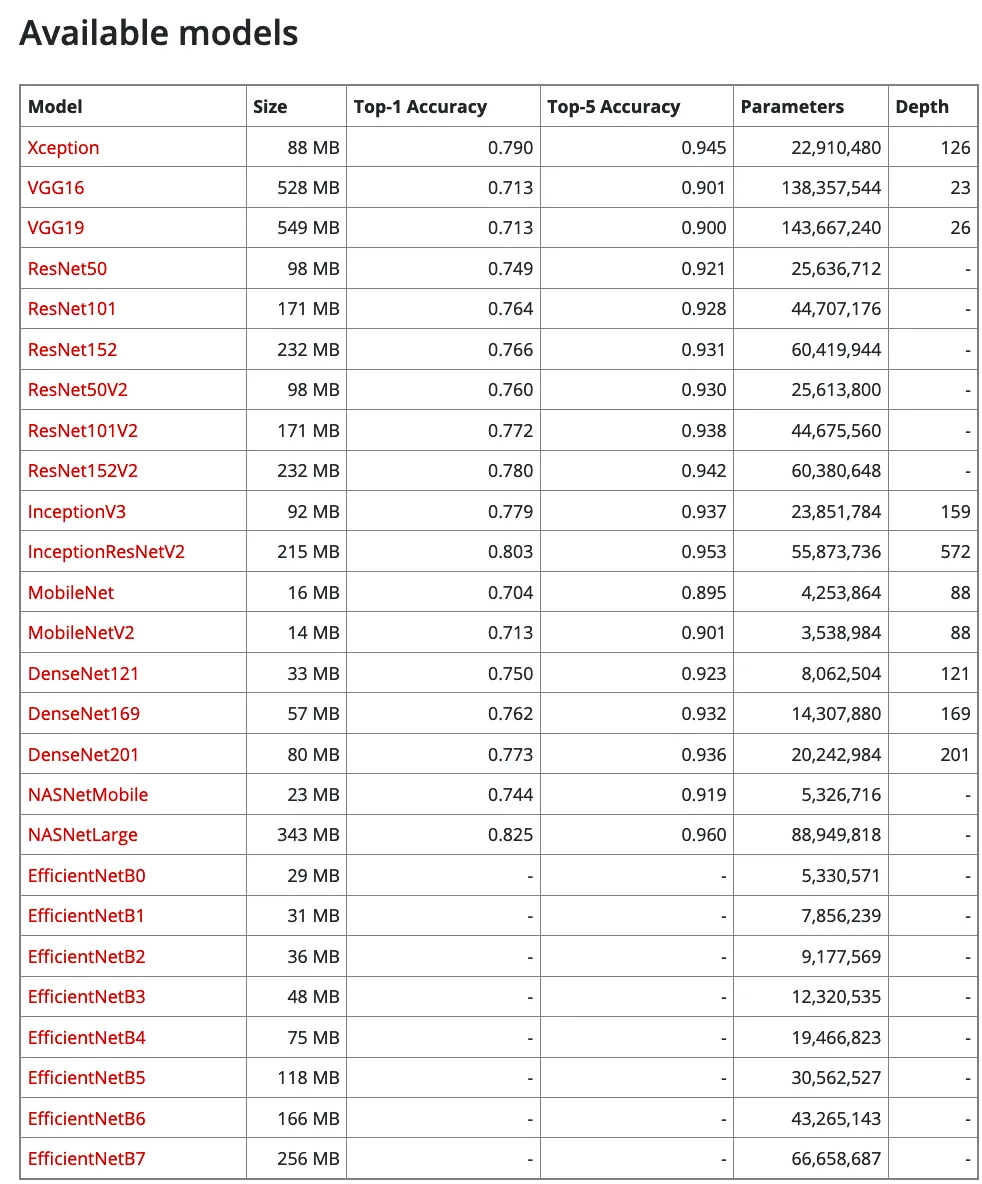

This chart shows us many options that we can proceed with, for the sake of time and available hardware we decided to test out 2, VGG16 and ResNet50.

Chart from:
https://medium.com/@blant.jesse/transfer-learning-neur-12df2f55b601

### ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 4951 images belonging to 5 classes.
Found 1415 images belonging to 5 classes.
94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_18 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_19 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 25691013 (98.00 MB)
Trainable params: 2103301 (8.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
154/154 [==============================] - 354s 2s/step - loss: 1.8487 - accuracy: 0.2405 - val_loss: 1.5856 - val_accuracy: 0.2585
Epoch 2/10
154/154 [==============================] - 344s 2s/step - loss: 1.5682 - accuracy: 0.2720 - val_loss: 1.5644 - val_accuracy: 0.2635
Epoch 3/10
154/154 [==============================] - 354s 2s/step - loss: 1.5639 - accuracy: 0.2793 - val_loss: 1.5545 - val_accuracy: 0.2734
Epoch 4/10
154/154 [==============================] - 351s 2s/step - loss: 1.5534 - accuracy: 0.2846 - val_loss: 1.5571 - val_accuracy: 0.2685
Epoch 5/10
154/154 [==============================] - 351s 2s/step - loss: 1.5445 - accuracy: 0.2946 - val_loss: 1.5601 - val_accuracy: 0.2727
Epoch 6/10
154/154 [==============================] - 342s 2s/step - loss: 1.5367 - accuracy: 0.3011 - val_loss: 1.5539 - val_accuracy: 0.2855
Epoch 7/10
154/154 [==============================] - 340s 2s/step - loss: 1.5338 - accuracy: 0.2956 - val_loss: 1.5552 - val_accuracy: 0.2763

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Found 707 images belonging to 5 classes.
23/23 [==============================] - 38s 2s/step - loss: 1.5787 - accuracy: 0.3055
Test Loss: 1.5786525011062622, Test Accuracy: 0.3055162727832794


This works better than before, accuracy went up with not much change in loss in comparison to the previous models we tried. Now onto VGG16.

### VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Found 4951 images belonging to 5 classes.
Found 1415 images belonging to 5 classes.


In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_14 (Flatten)        (None, 25088)             0         
                                                                 
 dense_30 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 27562821 (105.14 MB)
Trainable params: 12848133 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
154/154 [==============================] - 964s 6s/step - loss: 10.1694 - accuracy: 0.2218 - val_loss: 1.5994 - val_accuracy: 0.2344
Epoch 2/10
154/154 [==============================] - 927s 6s/step - loss: 1.6332 - accuracy: 0.2196 - val_loss: 1.5920 - val_accuracy: 0.2308
Epoch 3/10
154/154 [==============================] - 997s 6s/step - loss: 1.6144 - accuracy: 0.2210 - val_loss: 1.5871 - val_accuracy: 0.2315
Epoch 4/10
 81/154 [==============>...............] - ETA: 5:47 - loss: 1.6150 - accuracy: 0.2319

KeyboardInterrupt: 

We stopped running this as we have already run the whole thing in a previous notebook and it is taking too long but here are the results from VGG16 from the previous notebook. Given to the time constraint we chose to continue along with ResNet50

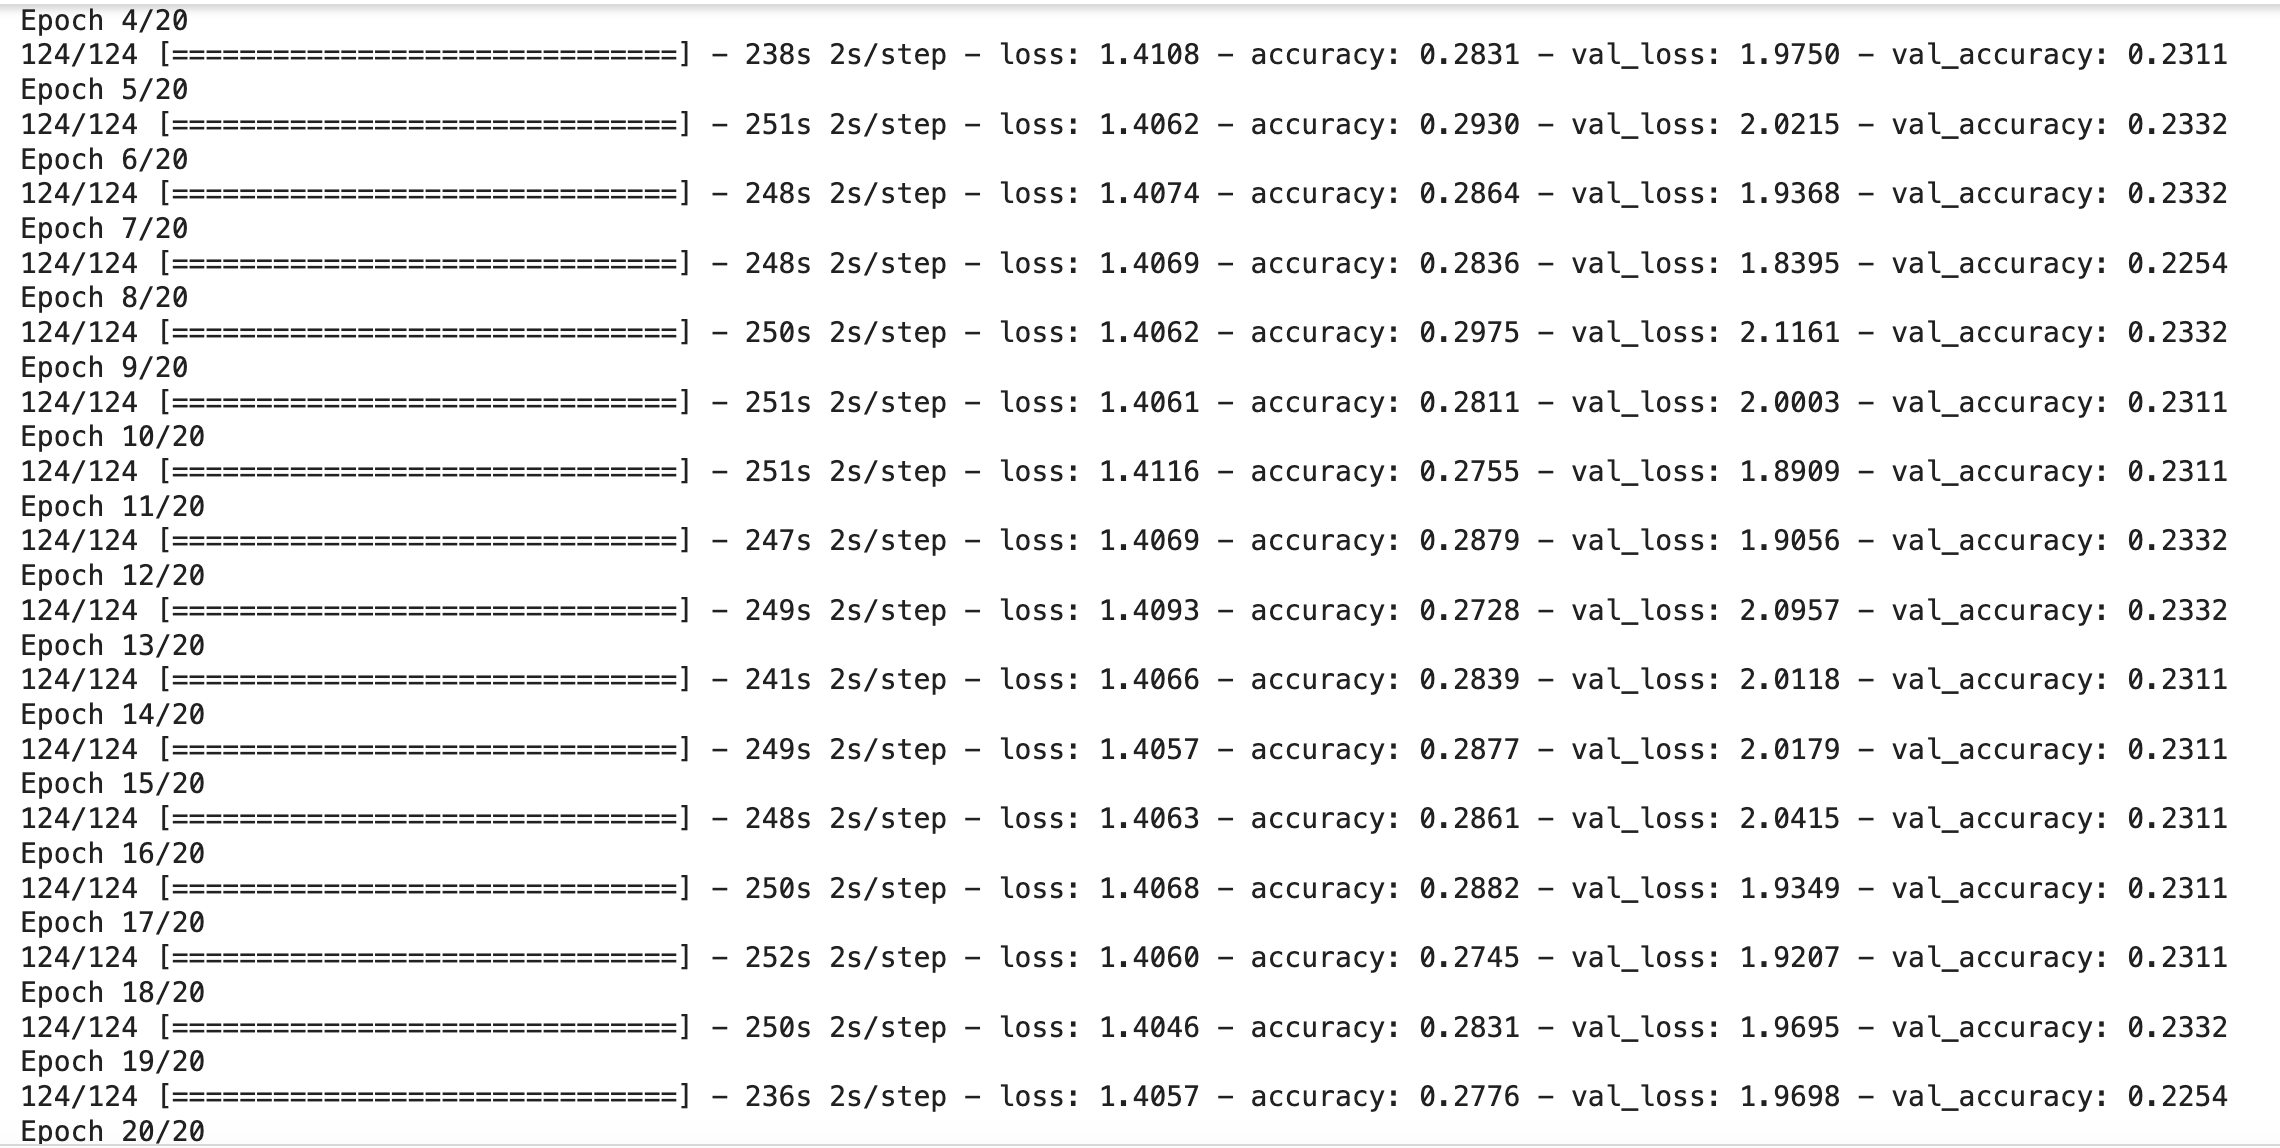

As you can see there is no benefit to using VGG16 over ResNet50 so we proceeded with ResNet50.

## Attempt 3 Redistributing the Data

In [ ]:
!ls drive/MyDrive/ds340/project/o

test  train  valid


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def create_dataset_copy(original_dir, copy_dir):
    """Copies the dataset from the original directory to a new directory."""
    if not os.path.exists(copy_dir):
        shutil.copytree(original_dir, copy_dir)
    else:
        print(f"Copy directory {copy_dir} already exists.")

original_base_dir = '/content/drive/MyDrive/ds340/project/data1'
copy_base_dir = '/content/drive/MyDrive/ds340/project/data_copy'

create_dataset_copy(original_base_dir, copy_base_dir)

def consolidate_images(base_dir, classes, set_names):
    """This function now works on the dataset copy."""
    consolidated_dir = os.path.join(base_dir, 'consolidated')
    os.makedirs(consolidated_dir, exist_ok=True)

    for cls in classes:
        class_dir = os.path.join(consolidated_dir, cls)
        os.makedirs(class_dir, exist_ok=True)
        for set_name in set_names:
            src_dir = os.path.join(base_dir, set_name, cls)
            if os.path.exists(src_dir):
                for file in os.listdir(src_dir):
                    src_file_path = os.path.join(src_dir, file)
                    dst_file_path = os.path.join(class_dir, file)
                    if not os.path.exists(dst_file_path):
                        shutil.copy(src_file_path, dst_file_path)  # Change from move to copy

classes = ['Folding Knife', 'Multi-tool Knife', 'Straight Knife', 'Utility Knife', 'Scissor']
set_names = ['train', 'valid', 'test']
consolidate_images(copy_base_dir, classes, set_names)

NameError: name 'move_files' is not defined

In [ ]:
import os

def count_images(directory):
    """ Count the number of images in each class directory. """
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):  # Ensure it's a directory
            count = len(os.listdir(class_path))
            class_counts[class_dir] = count
    return class_counts

train_counts = count_images(os.path.join('/content/drive/MyDrive/ds340/project/data_copy/train'))
val_counts = count_images(os.path.join('/content/drive/MyDrive/ds340/project/data_copy/valid'))
test_counts = count_images(os.path.join('/content/drive/MyDrive/ds340/project/data_copy/test'))

print("Training set counts:", train_counts)
print("Validation set counts:", val_counts)
print("Test set counts:", test_counts)


Training set counts: {'Utility Knife': 1110, 'Folding Knife': 1103, 'Multi-tool Knife': 1122, 'Straight Knife': 578, 'Scissor': 1039}
Validation set counts: {'Utility Knife': 327, 'Folding Knife': 319, 'Multi-tool Knife': 330, 'Straight Knife': 148, 'Scissor': 291}
Test set counts: {'Utility Knife': 177, 'Folding Knife': 155, 'Multi-tool Knife': 149, 'Straight Knife': 79, 'Scissor': 147}


In [ ]:
import os
import shutil

def consolidate_images(base_dir, classes, set_names):
    consolidated_dir = os.path.join(base_dir, 'consolidated')
    os.makedirs(consolidated_dir, exist_ok=True)

    for cls in classes:
        class_dir = os.path.join(consolidated_dir, cls)
        os.makedirs(class_dir, exist_ok=True)

        for set_name in set_names:
            src_dir = os.path.join(base_dir, set_name, cls)
            if os.path.exists(src_dir):
                for file in os.listdir(src_dir):
                    src_file_path = os.path.join(src_dir, file)
                    dst_file_path = os.path.join(class_dir, file)
                    if not os.path.exists(dst_file_path):
                        shutil.move(src_file_path, dst_file_path)

base_dir = '/content/drive/MyDrive/ds340/project/data_copy'
classes = ['Folding Knife', 'Multi-tool Knife', 'Straight Knife', 'Utility Knife', 'Scissor']
set_names = ['train', 'valid', 'test']
consolidate_images(base_dir, classes, set_names)


In [ ]:
from sklearn.model_selection import train_test_split

def redistribute_images(base_dir, train_ratio=0.60, val_ratio=0.20):
    consolidated_dir = os.path.join(base_dir, 'consolidated')
    classes = os.listdir(consolidated_dir)

    for cls in classes:
        class_dir = os.path.join(consolidated_dir, cls)
        files = [os.path.join(class_dir, f) for f in os.listdir(class_dir)]

        train_files, test_files = train_test_split(files, test_size=1-train_ratio-val_ratio, random_state=42)
        train_files, val_files = train_test_split(train_files, test_size=val_ratio/(train_ratio+val_ratio), random_state=42)

        def move_files(files, target_dir):
            os.makedirs(target_dir, exist_ok=True)
            for f in files:
                shutil.move(f, target_dir)

        move_files(train_files, os.path.join(base_dir, 'train', cls))
        move_files(val_files, os.path.join(base_dir, 'valid', cls))
        move_files(test_files, os.path.join(base_dir, 'test', cls))

redistribute_images(base_dir, train_ratio=0.70, val_ratio=0.15)


In [ ]:
import os

def count_images(directory):
    """ Count the number of images in each class directory. """
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):  # Ensure it's a directory
            count = len(os.listdir(class_path))
            class_counts[class_dir] = count
    return class_counts

train_counts = count_images(os.path.join('/content/drive/MyDrive/ds340/project/data_copy/train'))
val_counts = count_images(os.path.join('/content/drive/MyDrive/ds340/project/data_copy/valid'))
test_counts = count_images(os.path.join('/content/drive/MyDrive/ds340/project/data_copy/test'))

print("Training set counts:", train_counts)
print("Validation set counts:", val_counts)
print("Test set counts:", test_counts)


Training set counts: {'Utility Knife': 1129, 'Folding Knife': 1102, 'Multi-tool Knife': 1119, 'Straight Knife': 563, 'Scissor': 1033}
Validation set counts: {'Utility Knife': 242, 'Folding Knife': 238, 'Multi-tool Knife': 241, 'Straight Knife': 121, 'Scissor': 222}
Test set counts: {'Utility Knife': 243, 'Folding Knife': 237, 'Multi-tool Knife': 241, 'Straight Knife': 121, 'Scissor': 222}


Oversample Miniority Class - Data Augment

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
import os
import tensorflow as tf

base_dir = '/content/drive/MyDrive/ds340/project/data_copy'
class_name = 'Straight Knife'
train_dir = os.path.join(base_dir, 'train', class_name)
valid_dir = os.path.join(base_dir, 'valid', class_name)
test_dir = os.path.join(base_dir, 'test', class_name)

def augment_images(directory, num_augmented_per_image=5):
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(directory, filename)
            image = tf.keras.preprocessing.image.load_img(image_path)
            image = image.resize((150, 150))
            x = tf.keras.preprocessing.image.img_to_array(image)
            x = x.reshape((1,) + x.shape)

            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=directory, save_prefix='aug_', save_format='jpeg'):
                i += 1
                if i >= num_augmented_per_image:
                    break

augment_images(train_dir)
augment_images(valid_dir)
augment_images(test_dir)


In [ ]:
import os

def count_images(directory):
    """ Count the number of images in each class directory. """
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):  # Ensure it's a directory
            count = len(os.listdir(class_path))
            class_counts[class_dir] = count
    return class_counts

train_counts = count_images(os.path.join('/content/drive/MyDrive/ds340/project/data_copy/train'))
val_counts = count_images(os.path.join('/content/drive/MyDrive/ds340/project/data_copy/valid'))
test_counts = count_images(os.path.join('/content/drive/MyDrive/ds340/project/data_copy/test'))

print("Training set counts:", train_counts)
print("Validation set counts:", val_counts)
print("Test set counts:", test_counts)


Training set counts: {'Utility Knife': 1129, 'Folding Knife': 1102, 'Multi-tool Knife': 1119, 'Straight Knife': 3036, 'Scissor': 1033}
Validation set counts: {'Utility Knife': 242, 'Folding Knife': 238, 'Multi-tool Knife': 241, 'Straight Knife': 710, 'Scissor': 222}
Test set counts: {'Utility Knife': 243, 'Folding Knife': 237, 'Multi-tool Knife': 241, 'Straight Knife': 711, 'Scissor': 222}


In [ ]:
import os
import random

def undersample_directory(directory, target_count):
    """ Randomly remove files from a directory to reduce to target_count. """
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')]
    current_count = len(files)
    if current_count <= target_count:
        print(f"No need to remove files from {directory}, count is already at or below target.")
        return

    remove_count = current_count - target_count
    files_to_remove = random.sample(files, remove_count)

    for file in files_to_remove:
        os.remove(file)
    print(f"Removed {remove_count} files from {directory}")

base_dir = '/content/drive/MyDrive/ds340/project/data_copy'
train_uk_dir = os.path.join(base_dir, 'train', 'Utility Knife')
valid_uk_dir = os.path.join(base_dir, 'valid', 'Utility Knife')
test_uk_dir = os.path.join(base_dir, 'test', 'Utility Knife')

target_train_count = 700
target_valid_count = 150
target_test_count = 150

undersample_directory(train_uk_dir, target_train_count)
undersample_directory(valid_uk_dir, target_valid_count)
undersample_directory(test_uk_dir, target_test_count)


Removed 429 files from /content/drive/MyDrive/ds340/project/data_copy/train/Utility Knife
Removed 92 files from /content/drive/MyDrive/ds340/project/data_copy/valid/Utility Knife
Removed 93 files from /content/drive/MyDrive/ds340/project/data_copy/test/Utility Knife


In [ ]:
import os

def count_images(directory):
    """ Count the number of images in each class directory. """
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):  # Ensure it's a directory
            count = len(os.listdir(class_path))
            class_counts[class_dir] = count
    return class_counts

train_counts = count_images(os.path.join('/content/drive/MyDrive/ds340/project/data_copy/train'))
val_counts = count_images(os.path.join('/content/drive/MyDrive/ds340/project/data_copy/valid'))
test_counts = count_images(os.path.join('/content/drive/MyDrive/ds340/project/data_copy/test'))

print("Training set counts:", train_counts)
print("Validation set counts:", val_counts)
print("Test set counts:", test_counts)


Training set counts: {'Utility Knife': 700, 'Folding Knife': 1102, 'Multi-tool Knife': 1119, 'Straight Knife': 3036, 'Scissor': 1033}
Validation set counts: {'Utility Knife': 150, 'Folding Knife': 238, 'Multi-tool Knife': 241, 'Straight Knife': 710, 'Scissor': 222}
Test set counts: {'Utility Knife': 150, 'Folding Knife': 237, 'Multi-tool Knife': 241, 'Straight Knife': 711, 'Scissor': 222}


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def build_model(learning_rate, dropout_rate, optimizer):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
learning_rates = [0.001, 0.0001, 0.00001]
dropout_rates = [0.3, 0.5, 0.7]
optimizers = [tf.keras.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.SGD]

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

train_dir = '/content/drive/MyDrive/ds340/project/data_copy/train'
val_dir = '/content/drive/MyDrive/ds340/project/data_copy/valid'
test_dir = '/content/drive/MyDrive/ds340/project/data_copy/test'

# Define image size and batch size
img_height, img_width = 150, 150  # Adjust these dimensions to your specific dataset
batch_size = 32

# Prepare the data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 6990 images belonging to 5 classes.
Found 1561 images belonging to 5 classes.
Found 1561 images belonging to 5 classes.


In [ ]:
for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        for optimizer_class in optimizers:
            optimizer = optimizer_class(learning_rate=learning_rate)
            model = build_model(learning_rate, dropout_rate, optimizer)

            history = model.fit(train_generator,
                                steps_per_epoch=train_generator.samples // train_generator.batch_size,
                                epochs=10,
                                validation_data=validation_generator,
                                validation_steps=validation_generator.samples // validation_generator.batch_size)

            val_loss, val_acc = model.evaluate(validation_generator,
                                               steps=validation_generator.samples // validation_generator.batch_size)

            print(f'Learning Rate: {learning_rate}, Dropout Rate: {dropout_rate}, Optimizer: {optimizer_class.__name__}')
            print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
            print('-' * 50)

Epoch 1/10
196/196 [==============================] - 185s 932ms/step - loss: 1.3846 - accuracy: 0.4728 - val_loss: 1.3240 - val_accuracy: 0.5043
Epoch 2/10
196/196 [==============================] - 43s 217ms/step - loss: 1.3180 - accuracy: 0.4880 - val_loss: 1.2437 - val_accuracy: 0.5050
Epoch 3/10
196/196 [==============================] - 42s 216ms/step - loss: 1.2648 - accuracy: 0.4976 - val_loss: 1.1973 - val_accuracy: 0.5071
Epoch 4/10
196/196 [==============================] - 42s 213ms/step - loss: 1.2158 - accuracy: 0.5027 - val_loss: 1.1559 - val_accuracy: 0.5398
Epoch 5/10
196/196 [==============================] - 43s 217ms/step - loss: 1.1704 - accuracy: 0.5176 - val_loss: 1.1046 - val_accuracy: 0.5497
Epoch 6/10
196/196 [==============================] - 42s 213ms/step - loss: 1.1467 - accuracy: 0.5225 - val_loss: 1.1064 - val_accuracy: 0.5774
Epoch 7/10
196/196 [==============================] - 43s 218ms/step - loss: 1.1229 - accuracy: 0.5313 - val_loss: 1.0612 - val_a

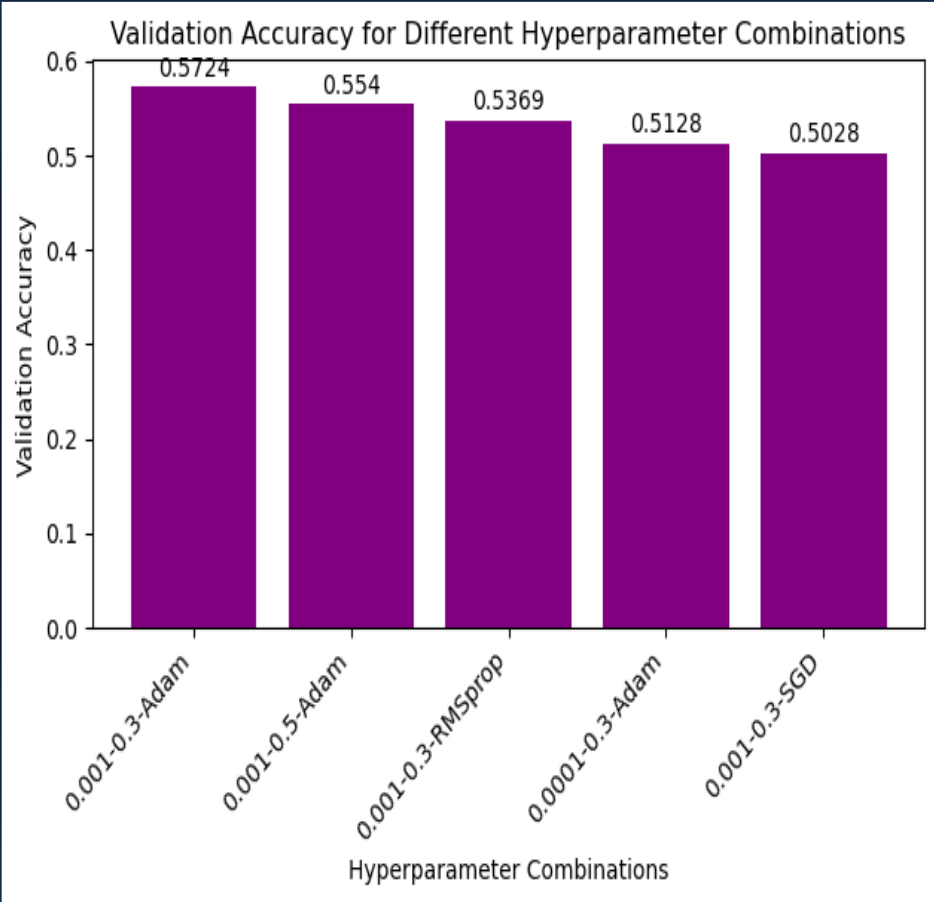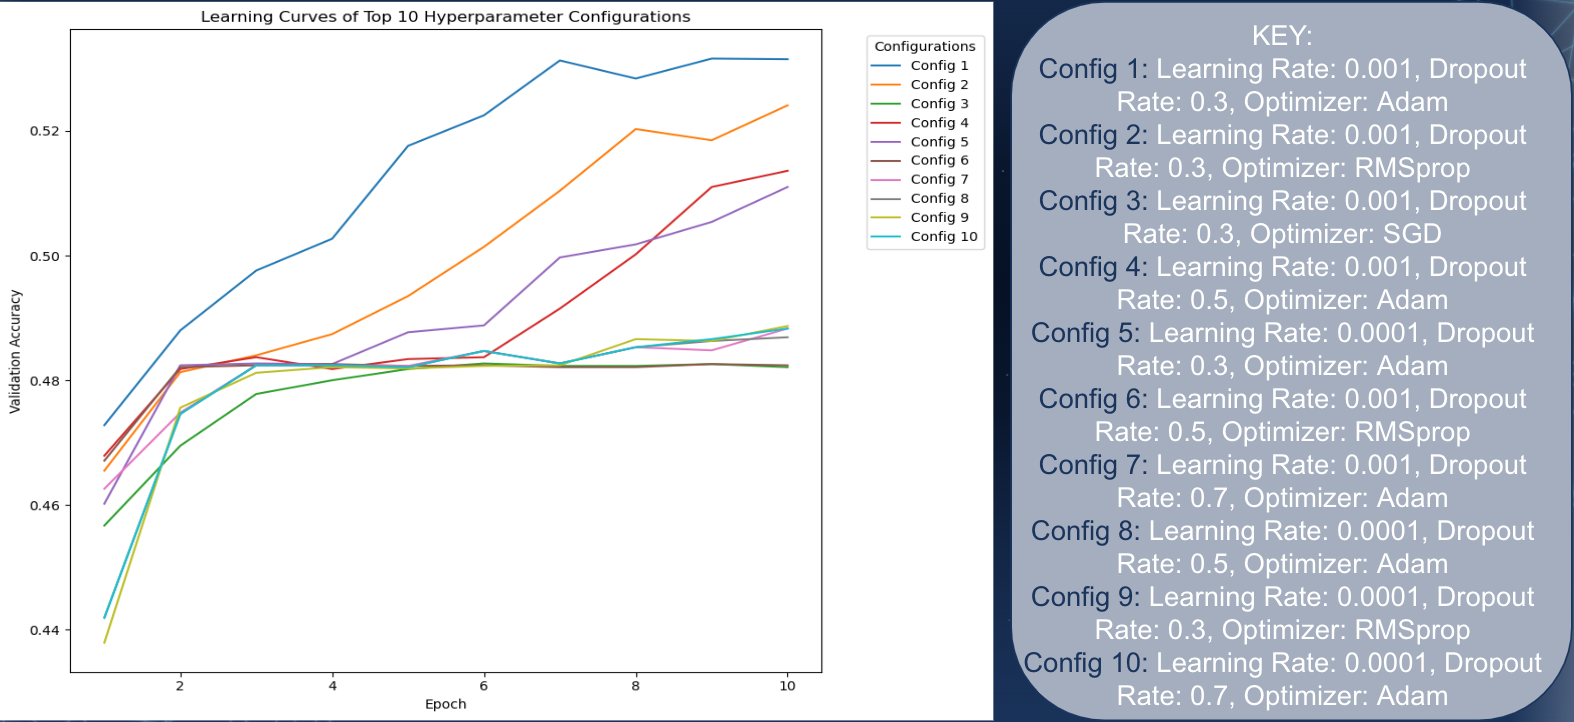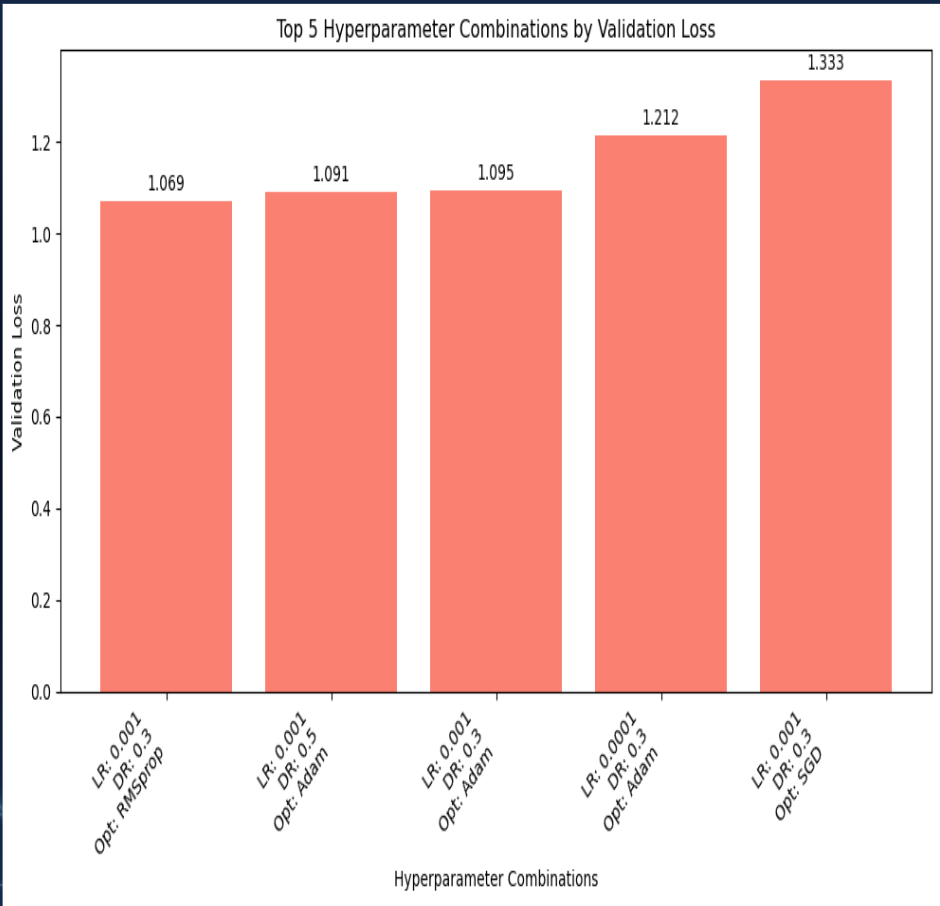

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model(learning_rate, dropout_rate):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

train_dir = '/content/drive/MyDrive/ds340/project/data_copy/train'
val_dir = '/content/drive/MyDrive/ds340/project/data_copy/valid'
test_dir = '/content/drive/MyDrive/ds340/project/data_copy/test'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

model = build_model(0.001, 0.3)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


Found 6990 images belonging to 5 classes.
Found 1561 images belonging to 5 classes.
Found 1561 images belonging to 5 classes.
Epoch 1/10
218/218 [==============================] - 462s 2s/step - loss: 1.3340 - accuracy: 0.4529 - val_loss: 1.1677 - val_accuracy: 0.4772
Epoch 2/10
218/218 [==============================] - 444s 2s/step - loss: 1.1824 - accuracy: 0.4843 - val_loss: 1.1117 - val_accuracy: 0.5046
Epoch 3/10
218/218 [==============================] - 451s 2s/step - loss: 1.1452 - accuracy: 0.4904 - val_loss: 1.1004 - val_accuracy: 0.5085
Epoch 4/10
218/218 [==============================] - 467s 2s/step - loss: 1.1237 - accuracy: 0.4902 - val_loss: 1.1396 - val_accuracy: 0.5312
Epoch 5/10
218/218 [==============================] - 445s 2s/step - loss: 1.1067 - accuracy: 0.4927 - val_loss: 1.0532 - val_accuracy: 0.5169
Epoch 6/10
218/218 [==============================] - 443s 2s/step - loss: 1.0965 - accuracy: 0.4957 - val_loss: 1.0614 - val_accuracy: 0.5117
Epoch 7/10
218/2

## What's New?
Here we try to see if we can detect where the contraband is. We will do this by starting off with the best model we had from previous results which was using ResNet, ADAM, 0.001 LR, and 0.3 DR.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def build_model(learning_rate, dropout_rate):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

train_dir = '/content/drive/MyDrive/ds340/project/data_copy/train'
val_dir = '/content/drive/MyDrive/ds340/project/data_copy/valid'
test_dir = '/content/drive/MyDrive/ds340/project/data_copy/test'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

model = build_model(0.001, 0.3)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


1/1 [==============================] - 0s 25ms/step


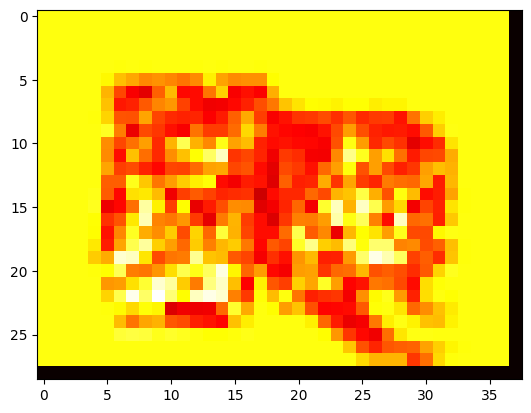

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array



def sliding_window(image, step_size, window_size):
    """
    Slide a window across the image
    """
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def classify_window(model, window):
    """
    Rescale and classify a given window
    """
    window = tf.image.resize(window, (224, 224))
    window = np.expand_dims(window, axis=0)
    preds = model.predict(window)
    return np.max(preds)



def create_heatmap(image, step_size, window_size):
    """
    Create a heatmap based on the sliding window analysis
    """
    heatmap = np.zeros((image.shape[0] // step_size, image.shape[1] // step_size))
    for (x, y, window) in sliding_window(image, step_size, window_size):
        if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
            continue  # Skip incomplete windows
        # Classify the window and update the heatmap
        prediction = classify_window(model, window)
        heatmap[y // step_size, x // step_size] = prediction
    return heatmap

image_path = '/content/drive/MyDrive/ds340/project/data_copy/test/Utility Knife/testingimage.jpg'
image = load_img(image_path, color_mode='rgb')
image = img_to_array(image)
heatmap = create_heatmap(image, step_size=32, window_size=(64, 64))

plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.show()


https://pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/

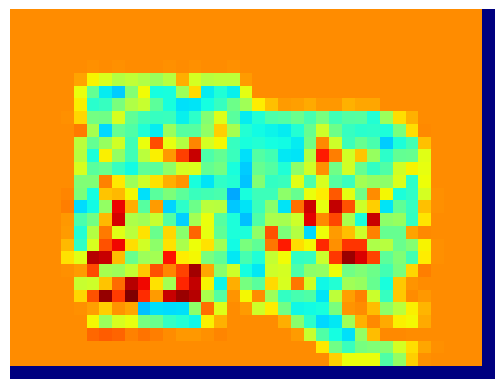

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

normalized_heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

colored_heatmap = cm.jet(normalized_heatmap)

original_image_path = '/content/drive/MyDrive/ds340/project/data_copy/test/Utility Knife/testingimage.jpg'
original_image = load_img(original_image_path, target_size=(colored_heatmap.shape[0], colored_heatmap.shape[1]))
original_image = img_to_array(original_image)

original_image = original_image.astype('float32') / 255

overlay_image = colored_heatmap[..., :3]
overlay_alpha = colored_heatmap[..., 3:]

combined_image = overlay_alpha * overlay_image + (1 - overlay_alpha) * original_image

if isinstance(combined_image, tf.Tensor):
    combined_image = combined_image.numpy()

combined_image = (combined_image * 255).astype('uint8')

plt.imshow(combined_image)
plt.axis('off')
plt.show()


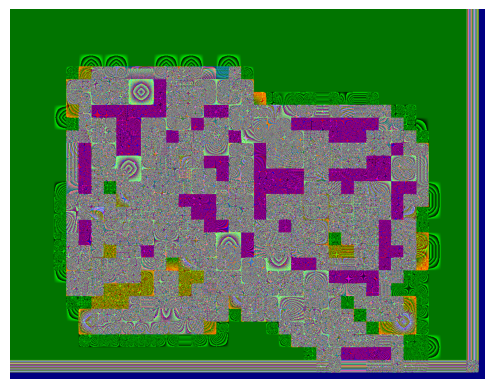

In [28]:

original_image_size = (954, 1225)
resized_combined_image = tf.image.resize(combined_image, original_image_size)

if isinstance(resized_combined_image, tf.Tensor):
    resized_combined_image = resized_combined_image.numpy()

resized_combined_image_uint8 = (resized_combined_image * 255).astype('uint8')

plt.imshow(resized_combined_image_uint8)
plt.axis('off')
plt.show()


What this means: The regions with brighter colors (yellow/red) indicate higher levels of activity or focus by the model, suggesting these are areas where the model has a stronger prediction of contraband being present. I provided a picture below of the original image and have highlighted where the contraband is and you can see it can detect the region, but has some doubts as it suspects other parts of the image could have the contraband.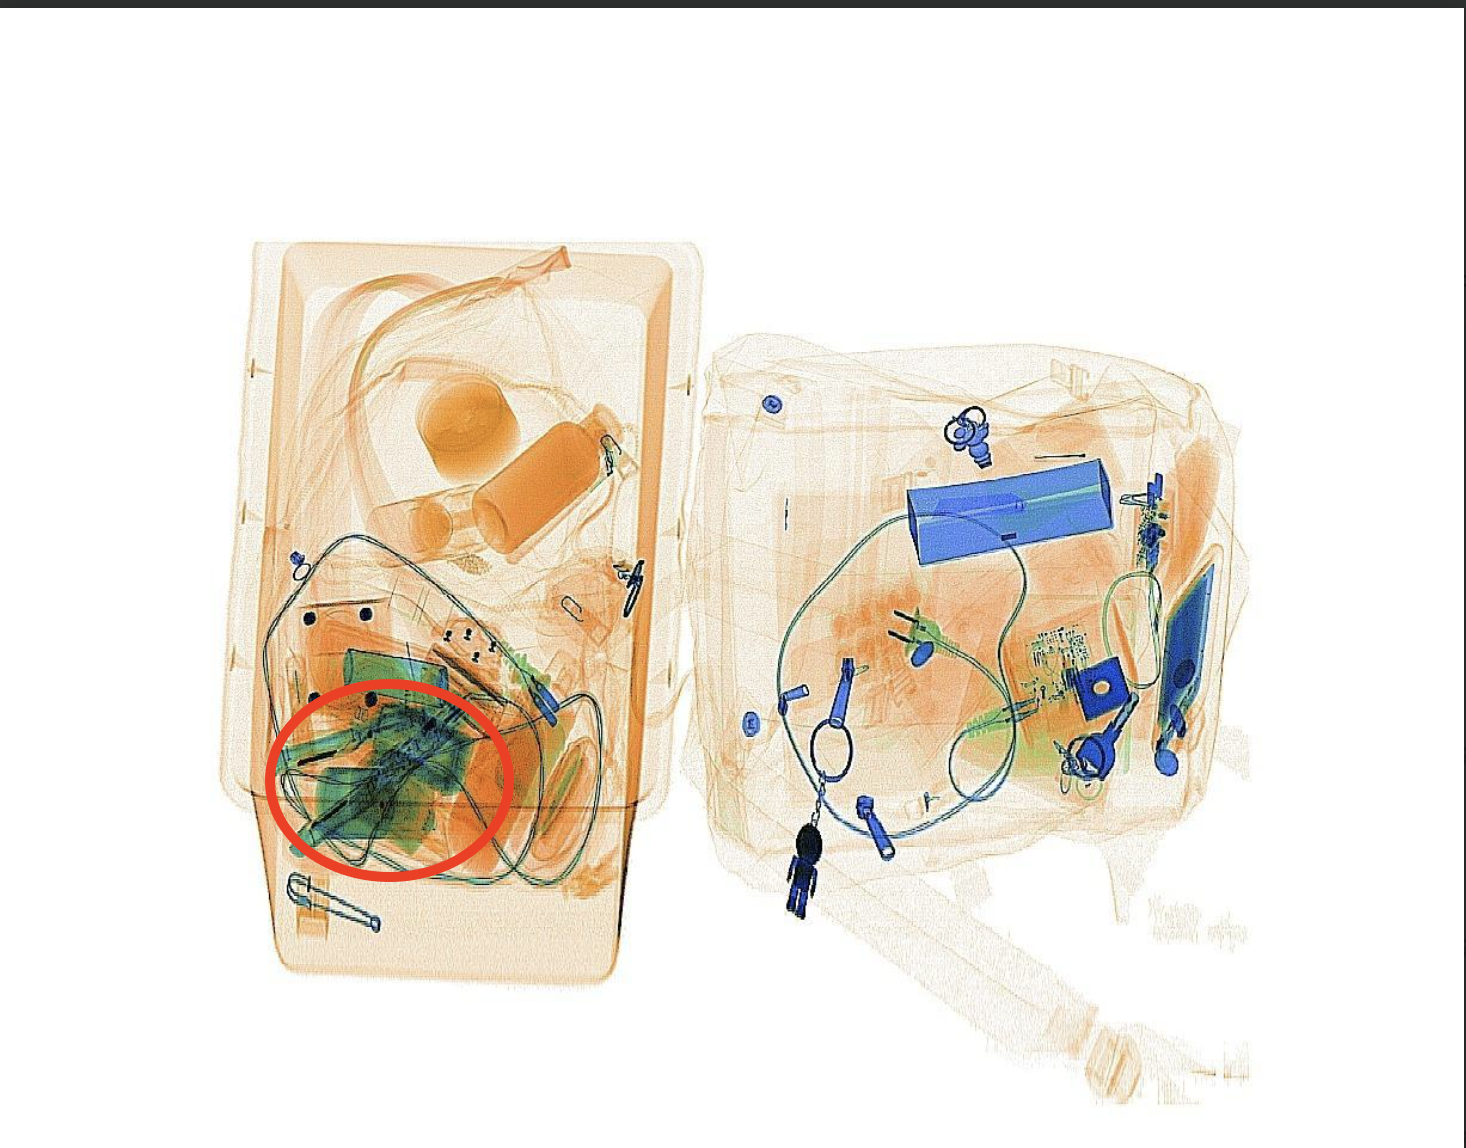

### Original Image

## A Brief Note About Some Difficulties We Encountered/ Final Remarks

* One of the biggest difficulties which can be apparent in this notebook is sharing models between one another and running them. These models and tests range from 3 different notebooks and rerunning them all to be added to this final polished notebook served as an obstacle. Fortunately we noticed this and planned to integrate them days before and let them run, but in some instances it was too inneficient to do this so for one test above there is a screenshot of the completed test running for V6616.

* This one was more so a challenge, and the main challenge we faced and that was the data. These images are already hard to make out with the naked eye. This challenge is what made this project feel rewarding and really led us to do extensive experimentation. Adding on considering the high resolution of these images it was almost impossible to run these tests (in terms of computing power) on the full resolution image so having to dumb it down makes it hard to be accurate.

* We hope that one day there could be technology developed for this as it can be an extremely effective safety measure and improve efficiency.
